# Land cover classification at the Mississppi Delta

In this notebook, you will use a k-means **unsupervised** clustering
algorithm to group pixels by similar spectral signatures. **k-means** is
an **exploratory** method for finding patterns in data. Because it is
unsupervised, you don’t need any training data for the model. You also
can’t measure how well it “performs” because the clusters will not
correspond to any particular land cover class. However, we expect at
least some of the clusters to be identifiable as different types of land
cover.

You will use the [harmonized Sentinal/Landsat multispectral
dataset](https://lpdaac.usgs.gov/documents/1698/HLS_User_Guide_V2.pdf).
You can access the data with an [Earthdata
account](https://www.earthdata.nasa.gov/learn/get-started) and the
[`earthaccess` library from
NSIDC](https://github.com/nsidc/earthaccess):

## STEP 1: SET UP

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Import all libraries you will need for this analysis</li>
<li>Configure GDAL parameters to help avoid connection errors:
<code>python      os.environ["GDAL_HTTP_MAX_RETRY"] = "5"      os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"</code></li>
</ol></div></div>

In [4]:
import os
import pickle
import re
import pathlib
import warnings

import cartopy.crs as ccrs
import earthaccess
from earthaccess import results
import earthpy as et
import geopandas as gpd
import geoviews as gv
import hvplot.pandas
import hvplot.xarray
import numpy as np
import pandas as pd
import rioxarray as rxr
import rioxarray.merge as rxrmerge
from tqdm.notebook import tqdm
import xarray as xr
from shapely.geometry import Polygon
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
import matplotlib.pyplot as plt

warnings.simplefilter('ignore')

In [5]:
# Prevent GDAL from quitting due to momentary disruptions
os.environ["GDAL_HTTP_MAX_RETRY"] = "5"
os.environ["GDAL_HTTP_RETRY_DELAY"] = "1"

Below you can find code for a caching **decorator** which you can use in
your code. To use the decorator:

``` python
@cached(key, override)
def do_something(*args, **kwargs):
    ...
    return item_to_cache
```

This decorator will **pickle** the results of running the
`do_something()` function, and only run the code if the results don’t
already exist. To override the caching, for example temporarily after
making changes to your code, set `override=True`. Note that to use the
caching decorator, you must write your own function to perform each
task!

In [6]:
def cached(func_key, override=False):
    """
    A decorator to cache function results
    
    Parameters
    ==========
    key: str
      File basename used to save pickled results
    override: bool
      When True, re-compute even if the results are already stored
    """
    def compute_and_cache_decorator(compute_function):
        """
        Wrap the caching function
        
        Parameters
        ==========
        compute_function: function
          The function to run and cache results
        """
        def compute_and_cache(*args, **kwargs):
            """
            Perform a computation and cache, or load cached result.
            
            Parameters
            ==========
            args
              Positional arguments for the compute function
            kwargs
              Keyword arguments for the compute function
            """
            # Add an identifier from the particular function call
            if 'cache_key' in kwargs:
                key = '_'.join((func_key, kwargs['cache_key']))
            else:
                key = func_key

            path = os.path.join(
                et.io.HOME, et.io.DATA_NAME, 'jars', f'{key}.pickle')
            
            # Check if the cache exists already or override caching
            if not os.path.exists(path) or override:
                # Make jars directory if needed
                os.makedirs(os.path.dirname(path), exist_ok=True)
                
                # Run the compute function as the user did
                result = compute_function(*args, **kwargs)
                
                # Pickle the object
                with open(path, 'wb') as file:
                    pickle.dump(result, file)
            else:
                # Unpickle the object
                with open(path, 'rb') as file:
                    result = pickle.load(file)
                    
            return result
        
        return compute_and_cache
    
    return compute_and_cache_decorator

## STEP 2: STUDY SITE

For this analysis, you will use a watershed from the [Water Boundary
Dataset](https://www.usgs.gov/national-hydrography/access-national-hydrography-products),
HU12 watersheds (WBDHU12.shp).

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Download the Water Boundary Dataset for region 8 (Mississippi)</li>
<li>Select watershed 080902030506</li>
<li>Generate a site map of the watershed</li>
</ol>
<p>Try to use the <strong>caching decorator</strong></p></div></div>

We chose this watershed because it covers parts of New Orleans and is
near the Mississippi Delta. Deltas are boundary areas between the land
and the ocean, and as a result tend to contain a rich variety of
different land cover and land use types.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-response"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>Write a 2-3 sentence <strong>site description</strong> (with
citations) of this area that helps to put your analysis in context.</p></div></div>

In [15]:
# Applying the cached decorator 
@cached('region_08', override=False)
def download_watershed_bounds(boundary_filename, huc):
    """
    Download a USGS watershed boundary dataset.

    Args:
    boundary_filename (str): USGS National Map regional shapefile name.
    huc (int): USGS Hydrologic Unit Code.

    Returns:
    geopandas.GeoDataFrame: Regional watershed boundary.  
    """
    water_boundary_url = (
        "https://prd-tnm.s3.amazonaws.com/StagedProducts/Hydrography/WBD/"
        f"HU2/Shape/{boundary_filename}.zip"
    )
    # Download data 
    wbd_dir = et.data.get_data(url=water_boundary_url)

    # Join shapefile path
    hu12_shape_path = os.path.join(wbd_dir, 'Shape', f'WBDHU{huc}.shp')

    # Load dataset

    # Pyogrio provides fast, bulk-oriented read and write access to GDAL 
    # vector data sources, such as ESRI Shapefile
    hu12_gdf = gpd.read_file(hu12_shape_path, engine='pyogrio')

    return hu12_gdf

In [16]:
# Download watershed boundaries dataset

# Hydrologic Unit level "HU2" indicates a large region 
region = '08'

boundary_filename = f'WBD_{region}_HU2_Shape'

# HU12: a very small subwatershed within a HU2 region
huc = 12 

wbd_gdf = download_watershed_bounds(boundary_filename, huc)

wbd_gdf.head(1)

tnmid  \
0  {8AFB1AF9-7296-4303-89DE-14CD073B859A}   

                               metasource                        sourcedata  \
0  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   

                                          sourceorig sourcefeat   loaddate  \
0  Natural Resources and Conservation Service and...       None 2024-08-15   

      referenceg  areaacres  areasqkm states  ...                      name  \
0  535297,540579   29441.81    119.15     LA  ...  Gourd Bayou-Youngs Bayou   

  hutype     humod         tohuc noncontrib  noncontr_1  shape_Leng  \
0      S  LE,ID,DD  080500011308        0.0         0.0         NaN   

   shape_Area  ObjectID                                           geometry  
0         NaN         1  POLYGON ((-92.00021 32.53586, -91.99994 32.535...  

[1 rows x 21 columns]

In [6]:
wbd_gdf.columns

Index(['tnmid', 'metasource', 'sourcedata', 'sourceorig', 'sourcefeat',
       'loaddate', 'referenceg', 'areaacres', 'areasqkm', 'states', 'huc12',
       'name', 'hutype', 'humod', 'tohuc', 'noncontrib', 'noncontr_1',
       'shape_Leng', 'shape_Area', 'ObjectID', 'geometry'],
      dtype='object')

In [17]:
# Select watershed 

watershed = '080902030506'

ms_delta_gdf = (
    wbd_gdf[wbd_gdf[f'huc{huc}'] # select HU12 subregion
    .isin([watershed])] # subset for Mississippi Delta 
    .dissolve() # dissolve geometries into single observation
)

ms_delta_gdf

geometry  \
0  POLYGON ((-89.97047 29.74687, -89.96593 29.750...   

                                    tnmid  \
0  {E942B72E-599E-48F5-908A-EA5265701C14}   

                               metasource                        sourcedata  \
0  {511D2AC8-11BA-45FC-AB98-F69D693D4C44}  Watershed Boundary Dataset (WBD)   

                                          sourceorig sourcefeat   loaddate  \
0  Natural Resources and Conservation Service and...       None 2024-08-15   

      referenceg  areaacres  areasqkm  ...         huc12  \
0  536881,539539   37355.86    151.17  ...  080902030506   

                        name hutype humod         tohuc noncontrib  \
0  Manuel Canal-Spanish Lake      D    GC  080902030508        0.0   

   noncontr_1  shape_Leng  shape_Area  ObjectID  
0         0.0         NaN         NaN      2560  

[1 rows x 21 columns]

In [18]:
# Plot watershed 

(
    ms_delta_gdf.to_crs(ccrs.Mercator())
    .hvplot(
        alpha=.2, fill_color='white', tiles='EsriImagery',
        crs=ccrs.Mercator())
    .opts(width=600, height=400)
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

The Manuel Canal-Spanish Lake watershed exists as part of New Orleans near the Mississippi Delta (river on left) and covers 37,355.86 acres. The Manual Canal is a [major water conduit](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://pubs.usgs.gov/of/1992/0274/report.pdf) with banks that have been elevated by 15 to 25 cm due to soil deposition and normal tidal conditions distributing water between marsh and the canal. The marsh ecology is characterized by the daily tidal flow, receiving fresh nutrients when the tide comes in, and releasing decaying organic matter as the tide goes out. 

Data Description: The National Map: 12-digit Hydrologic Unit (Subwatershed) Dataset contains polygon boundaries for the United States, Puerto Rico, and the U.S. Virgin Islands compiled from the USGS National Hydrography Dataset and the USDA National Resources Conservation Service Water Boundary Dataset. 

Data Citation: USGS. (n.d.). *The National Map: 12-digit HU (Subwatershed)* [Data set]. https://hydro.nationalmap.gov/arcgis/rest/services/wbd/MapServer/6

## STEP 3: MULTISPECTRAL DATA

### Search for data

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Log in to the <code>earthaccess</code> service using your Earthdata
credentials:
<code>python      earthaccess.login(persist=True)</code></li>
<li>Modify the following sample code to search for granules of the
HLSL30 product overlapping the watershed boundary from May to October
2023 (there should be 76 granules):
<code>python      results = earthaccess.search_data(          short_name="...",          cloud_hosted=True,          bounding_box=tuple(gdf.total_bounds),          temporal=("...", "..."),      )</code></li>
</ol></div></div>

In [13]:
# Log in to earthaccess

earthaccess.login(strategy="interactive", persist=True)

In [19]:
# Search for HLS tiles

ms_delta_results = earthaccess.search_data(
    short_name="HLSL30", # Harmonized Sentinal/Landsat multispectral dataset
    cloud_hosted=True,
    bounding_box=tuple(ms_delta_gdf.total_bounds),
    temporal=("2023-05-01", "2023-10-01"))

print(len(ms_delta_results), "granules total")

76 granules total


### Compile information about each granule

I recommend building a GeoDataFrame, as this will allow you to plot the
granules you are downloading and make sure they line up with your
shapefile. You could also use a DataFrame, dictionary, or a custom
object to store this information.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>For each search result:
<ol type="1">
<li>Get the following information (HINT: look at the [‘umm’] values for
each search result):
<ul>
<li>granule id (UR)</li>
<li>datetime</li>
<li>geometry (HINT: check out the shapely.geometry.Polygon class to
convert points to a Polygon)</li>
</ul></li>
<li>Open the granule files. I recomment opening one granule at a time,
e.g. with (<code>earthaccess.open([result]</code>).</li>
<li>For each file (band), get the following information:
<ul>
<li>file handler returned from <code>earthaccess.open()</code></li>
<li>tile id</li>
<li>band number</li>
</ul></li>
</ol></li>
<li>Compile all the information you collected into a GeoDataFrame</li>
</ol></div></div>

In [20]:
@cached('granule_metadata', override=False)
def build_granule_metadata(hls_results):
    """
    Collect granule metadata from HLS tiles.

    Args:
    hls_results (List[DataGranule]): HLS search results list.

    Returns:
    granule_metadata (list): List of granule metadata dictionaries.
    """

    # Find all the metadata in the file
    granule_metadata = [] 

    # Loop through each granule
    for result in tqdm(hls_results):

        # Granule ID
        granule_id = result['umm']['GranuleUR']

        # Get datetime 
        temporal_coverage = results.DataCollection.get_umm(
            result, 'TemporalExtent')
        granule_date = (pd.to_datetime(
            temporal_coverage['RangeDateTime']['BeginningDateTime']
        ).strftime('%Y-%m-%d'))

        print(f'Processing date {granule_date}. Granule ID: {granule_id}.')

        # Assemble granule polygon 
        spatial_ext = results.DataCollection.get_umm(result, 'SpatialExtent')
        granule_geo = spatial_ext['HorizontalSpatialDomain']['Geometry']
        granule_points = granule_geo['GPolygons'][0]['Boundary']['Points']
        granule_coords = [tuple(point.values()) for point in granule_points]
        granule_polygon = Polygon(granule_coords)

        # Open granule files
        granule_files = earthaccess.open([result])

        # Use () to select the desired name and only output that name
        uri_re = re.compile(
            r"v2.0/(HLS.L30.*.tif)"
        )

        # Select unique tiles
        tile_id_re = re.compile(
            r"HLSL30.020/(HLS.L30..*.v2.0)/HLS"
        )

        # Grab band IDs
        band_id_re = re.compile(
            r"HLS.L30..*v2.0.(\D{1}.*).tif"
        )

        # Collect file metadata
        for uri in granule_files:

            # Make sure uri has full_name property first
            if (hasattr(uri, 'full_name')):
                file_name = uri_re.findall(uri.full_name)[0]
                tile_id = tile_id_re.findall(uri.full_name)[0]
                band_id = band_id_re.findall(uri.full_name)[0]

                # Only keep spectral bands and cloud Fmask
                # Exclude sun and view angles
                exclude_files = ['SAA', 'SZA', 'VAA', 'VZA']

                if band_id not in exclude_files:
                    granule_metadata.append({
                        'filename': file_name,
                        'tile_id': tile_id,
                        'band_id': band_id,
                        'granule_id': granule_id,
                        'granule_date': granule_date,
                        'granule_polygon': granule_polygon,
                        'uri': uri
                    })

    # Concatenate granule metadata 
    granule_metadata_df = pd.DataFrame(
        data=granule_metadata, columns=[
            'filename', 'tile_id', 'band_id', 'granule_id', 
            'granule_date', 'granule_polygon', 'uri'])

    granule_results_gdf = gpd.GeoDataFrame(
            granule_metadata_df, 
            geometry=granule_metadata_df['granule_polygon'], 
            crs="EPSG:4326")

    return granule_results_gdf 

In [21]:
ms_delta_metadata = build_granule_metadata(ms_delta_results)

  0%|          | 0/76 [00:00<?, ?it/s]

Processing date 2023-05-04. Granule ID: HLS.L30.T16RBT.2023124T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-04. Granule ID: HLS.L30.T15RYN.2023124T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-04. Granule ID: HLS.L30.T15RYP.2023124T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-04. Granule ID: HLS.L30.T16RBU.2023124T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-12. Granule ID: HLS.L30.T16RBT.2023132T163144.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-12. Granule ID: HLS.L30.T15RYP.2023132T163144.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-12. Granule ID: HLS.L30.T15RYN.2023132T163144.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-12. Granule ID: HLS.L30.T16RBU.2023132T163144.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-20. Granule ID: HLS.L30.T15RYP.2023140T163123.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-20. Granule ID: HLS.L30.T16RBT.2023140T163123.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-20. Granule ID: HLS.L30.T16RBU.2023140T163123.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-20. Granule ID: HLS.L30.T15RYN.2023140T163123.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-28. Granule ID: HLS.L30.T15RYN.2023148T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-28. Granule ID: HLS.L30.T16RBU.2023148T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-28. Granule ID: HLS.L30.T16RBT.2023148T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-05-28. Granule ID: HLS.L30.T15RYP.2023148T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-05. Granule ID: HLS.L30.T16RBU.2023156T163128.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-05. Granule ID: HLS.L30.T15RYP.2023156T163128.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-05. Granule ID: HLS.L30.T16RBT.2023156T163128.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-05. Granule ID: HLS.L30.T15RYN.2023156T163128.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-13. Granule ID: HLS.L30.T16RBU.2023164T163126.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-13. Granule ID: HLS.L30.T15RYP.2023164T163126.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-13. Granule ID: HLS.L30.T15RYN.2023164T163126.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-13. Granule ID: HLS.L30.T16RBT.2023164T163126.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-21. Granule ID: HLS.L30.T15RYP.2023172T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-21. Granule ID: HLS.L30.T15RYN.2023172T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-21. Granule ID: HLS.L30.T16RBU.2023172T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-21. Granule ID: HLS.L30.T16RBT.2023172T163134.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-29. Granule ID: HLS.L30.T16RBU.2023180T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-29. Granule ID: HLS.L30.T15RYP.2023180T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-29. Granule ID: HLS.L30.T16RBT.2023180T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-06-29. Granule ID: HLS.L30.T15RYN.2023180T163132.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-07. Granule ID: HLS.L30.T16RBU.2023188T163146.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-07. Granule ID: HLS.L30.T15RYP.2023188T163146.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-07. Granule ID: HLS.L30.T16RBT.2023188T163146.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-07. Granule ID: HLS.L30.T15RYN.2023188T163146.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-15. Granule ID: HLS.L30.T15RYN.2023196T163142.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-15. Granule ID: HLS.L30.T16RBU.2023196T163142.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-15. Granule ID: HLS.L30.T15RYP.2023196T163142.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-15. Granule ID: HLS.L30.T16RBT.2023196T163142.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-23. Granule ID: HLS.L30.T15RYP.2023204T163150.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-23. Granule ID: HLS.L30.T16RBU.2023204T163150.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-23. Granule ID: HLS.L30.T15RYN.2023204T163150.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-23. Granule ID: HLS.L30.T16RBT.2023204T163150.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-31. Granule ID: HLS.L30.T16RBU.2023212T163147.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-31. Granule ID: HLS.L30.T16RBT.2023212T163147.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-31. Granule ID: HLS.L30.T15RYN.2023212T163147.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-07-31. Granule ID: HLS.L30.T15RYP.2023212T163147.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-08. Granule ID: HLS.L30.T16RBU.2023220T163157.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-08. Granule ID: HLS.L30.T15RYN.2023220T163157.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-08. Granule ID: HLS.L30.T15RYP.2023220T163157.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-08. Granule ID: HLS.L30.T16RBT.2023220T163157.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-16. Granule ID: HLS.L30.T15RYP.2023228T163152.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-16. Granule ID: HLS.L30.T16RBU.2023228T163152.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-16. Granule ID: HLS.L30.T16RBT.2023228T163152.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-16. Granule ID: HLS.L30.T15RYN.2023228T163152.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-24. Granule ID: HLS.L30.T15RYP.2023236T163205.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-24. Granule ID: HLS.L30.T16RBT.2023236T163205.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-24. Granule ID: HLS.L30.T15RYN.2023236T163205.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-08-24. Granule ID: HLS.L30.T16RBU.2023236T163205.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-01. Granule ID: HLS.L30.T15RYP.2023244T163203.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-01. Granule ID: HLS.L30.T16RBU.2023244T163203.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-01. Granule ID: HLS.L30.T16RBT.2023244T163203.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-01. Granule ID: HLS.L30.T15RYN.2023244T163203.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-09. Granule ID: HLS.L30.T16RBU.2023252T163206.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-09. Granule ID: HLS.L30.T15RYP.2023252T163206.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-09. Granule ID: HLS.L30.T15RYN.2023252T163206.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-09. Granule ID: HLS.L30.T16RBT.2023252T163206.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-17. Granule ID: HLS.L30.T16RBU.2023260T163211.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-17. Granule ID: HLS.L30.T15RYP.2023260T163211.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-17. Granule ID: HLS.L30.T16RBT.2023260T163211.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-17. Granule ID: HLS.L30.T15RYN.2023260T163211.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-25. Granule ID: HLS.L30.T16RBT.2023268T163212.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-25. Granule ID: HLS.L30.T15RYN.2023268T163212.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-25. Granule ID: HLS.L30.T16RBU.2023268T163212.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

Processing date 2023-09-25. Granule ID: HLS.L30.T15RYP.2023268T163212.v2.0.


QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

### Open, crop, and mask data

This will be the most resource-intensive step. I recommend caching your
results using the `cached` decorator or by writing your own caching
code. I also recommend testing this step with one or two dates before
running the full computation.

This code should include at least one **function** including a
numpy-style docstring. A good place to start would be a function for
opening a single masked raster, applying the appropriate scale
parameter, and cropping.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>For each granule:
<ol type="1">
<li><p>Open the Fmask band, crop, and compute a quality mask for the
granule. You can use the following code as a starting point, making sure
that <code>mask_bits</code> contains the quality bits you want to
consider: ```python # Expand into a new dimension of binary bits bits =
( np.unpackbits(da.astype(np.uint8), bitorder=‘little’)
.reshape(da.shape + (-1,)) )</p>
<p># Select the required bits and check if any are flagged mask =
np.prod(bits[…, mask_bits]==0, axis=-1) ```</p></li>
<li><p>For each band that starts with ‘B’:</p>
<ol type="1">
<li>Open the band, crop, and apply the scale factor</li>
<li>Name the DataArray after the band using the <code>.name</code>
attribute</li>
<li>Apply the cloud mask using the <code>.where()</code> method</li>
<li>Store the DataArray in your data structure (e.g. adding a
GeoDataFrame column with the DataArray in it. Note that you will need to
remove the rows for unused bands)</li>
</ol></li>
</ol></li>
</ol></div></div>

In [22]:
np.unique(ms_delta_metadata.granule_date)

array(['2023-05-04', '2023-05-12', '2023-05-20', '2023-05-28',
       '2023-06-05', '2023-06-13', '2023-06-21', '2023-06-29',
       '2023-07-07', '2023-07-15', '2023-07-23', '2023-07-31',
       '2023-08-08', '2023-08-16', '2023-08-24', '2023-09-01',
       '2023-09-09', '2023-09-17', '2023-09-25'], dtype=object)

In [42]:
def process_image(uri, bounds_gdf, scale=1):
    """
    Load, crop, and scale a raster image

    Parameters
    ----------
    uri: file-like or path-like
      File accessor 
    bounds_gdf: gpd.GeoDataFrame
      Area of interest 

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # Load and scale
    da = rxr.open_rasterio(uri, masked=True).squeeze() * scale

    # Obtain crs from raster
    raster_crs = da.rio.crs

    # Match coordinate reference systems
    bounds_gdf = bounds_gdf.to_crs(raster_crs)

    # Crop to site boundaries
    cropped_da = da.rio.clip_box(*bounds_gdf.total_bounds)

    return cropped_da

In [24]:
def process_cloud_mask(cloud_uri, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor 
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """
    cloud_da = rxr.open_rasterio(cloud_uri, mask_and_scale=True).squeeze()

    # Get the cloud mask as bits
    cloud_bits = (
        np.unpackbits(
            (
                # Get the cloud mask as an array
                cloud_da.values
                # of 8-bit integers
                .astype('uint8')
                # With an extra axis to unpack the bits into
                [:, :, np.newaxis]
            ), 
            # List the least significant bit first to match the user guide
            bitorder='little',
            # Expand the array in a new dimension
            axis=-1)
    )
    
    # Add up the bits for each pixel
    cloud_mask = np.sum(
        # Select bits 
        cloud_bits[:, :, bits_to_mask], 
        # Sum along the bit axis
        axis=-1
    )

    # Mask the pixel if the sum is greater than 0
    # (If any of the bits are True)
    cloud_mask = cloud_mask == 0

    return cloud_mask

In [25]:
# Harmonized Landsat Sentinel-2 (HLS) band code name L8
bands = {
    'B01': 'aerosol',
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    # Near-infrared narrow (0.85 – 0.88 micrometers)
    'B05': 'nir',
    # Short-wave infrared (SWIR) wavelength 1.57 – 1.65 µm
    'B06': 'swir1',
    # SWIR (2.11 – 2.29 µm)
    'B07': 'swir2',
    'B09': 'cirrus',
    # Thermal infrared 1 (10.60 – 11.19 µm)
    'B10': 'thermalir1',
    # Thermal infrared 2 (11.50 – 12.51 µm)
    'B11': 'thermalir2'
}

# HLS Quality Assessment layer bits
bits_to_mask = [
    1, # Cloud
    2, # Adjacent to cloud/shadow
    3  # Cloud shadow
]

In [43]:
@cached('delta_reflectance_da_df', override=False)
def compute_reflectance_da(file_df, boundary_gdf):
    """
    Connect to files over VSI (Virtual Filesystem Interface), 
    crop, cloud mask, and wrangle data.
    
    Returns a reflectance DataArray within file DataFrame.
    
    Parameters
    ==========
    file_df : pd.DataFrame
        File connection and metadata 
    boundary_gdf : gpd.GeoDataFrame
        Boundary use to crop the data
    """
    granule_da_rows= []

    # unique dated data granules
    tile_groups = file_df.groupby(['granule_date', 'tile_id'])

    for (granule_date, tile_id), tile_df in tqdm(tile_groups):
        print(f'Processing granule {tile_id} {granule_date}')

        # Grab Fmask row from tile group
        Fmask_row = tile_df.loc[tile_df['band_id'] == 'Fmask']
        # Load cloud path
        cloud_path = Fmask_row.uri.values[0]
        # Compute cloud mask
        cloud_mask = process_cloud_mask(cloud_path, bits_to_mask)

        # Load spectral bands
        band_groups = tile_df.groupby('band_id')

        for band_name, band_df in band_groups:
            for index, row in band_df.iterrows():
                # Process band and retain band scale
                cropped_da = process_image(row.uri, boundary_gdf, scale=0.0001)
                cropped_da.name = band_name

                # Apply mask on band to remove unwanted cloud data
                row['da'] = cropped_da.where(~cropped_da.isin(cloud_mask))

                # Store the resulting DataArray
                granule_da_rows.append(row.to_frame().T)

    # Reassemble the metadata DataFrame
    return pd.concat(granule_da_rows)

In [44]:
delta_reflectance_da_df = compute_reflectance_da(ms_delta_metadata, ms_delta_gdf)

  0%|          | 0/76 [00:00<?, ?it/s]

Processing granule HLS.L30.T15RYN.2023124T163132.v2.0 2023-05-04
Processing granule HLS.L30.T15RYP.2023124T163132.v2.0 2023-05-04
Processing granule HLS.L30.T16RBT.2023124T163132.v2.0 2023-05-04
Processing granule HLS.L30.T16RBU.2023124T163132.v2.0 2023-05-04
Processing granule HLS.L30.T15RYN.2023132T163144.v2.0 2023-05-12
Processing granule HLS.L30.T15RYP.2023132T163144.v2.0 2023-05-12
Processing granule HLS.L30.T16RBT.2023132T163144.v2.0 2023-05-12
Processing granule HLS.L30.T16RBU.2023132T163144.v2.0 2023-05-12
Processing granule HLS.L30.T15RYN.2023140T163123.v2.0 2023-05-20
Processing granule HLS.L30.T15RYP.2023140T163123.v2.0 2023-05-20
Processing granule HLS.L30.T16RBT.2023140T163123.v2.0 2023-05-20
Processing granule HLS.L30.T16RBU.2023140T163123.v2.0 2023-05-20
Processing granule HLS.L30.T15RYN.2023148T163134.v2.0 2023-05-28
Processing granule HLS.L30.T15RYP.2023148T163134.v2.0 2023-05-28
Processing granule HLS.L30.T16RBT.2023148T163134.v2.0 2023-05-28
Processing granule HLS.L3

### Merge and Composite Data

You will notice for this watershed that: 1. The raster data for each
date are spread across 4 granules 2. Any given image is incomplete
because of clouds

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li><p>For each band:</p>
<ol type="1">
<li><p>For each date:</p>
<ol type="1">
<li>Merge all 4 granules</li>
<li>Mask any negative values created by interpolating from the nodata
value of -9999 (<code>rioxarray</code> should account for this, but
doesn’t appear to when merging. If you leave these values in they will
create problems down the line)</li>
</ol></li>
<li><p>Concatenate the merged DataArrays along a new date
dimension</p></li>
<li><p>Take the mean in the date dimension to create a composite image
that fills cloud gaps</p></li>
<li><p>Add the band as a dimension, and give the DataArray a
name</p></li>
</ol></li>
<li><p>Concatenate along the band dimension</p></li>
</ol></div></div>

In [45]:
@cached('delta_reflectance_da', override=False)
def create_composite_da(granule_da_df):
    """
    Create a composite DataArray from a DataFrame containing granule
    metadata and corresponding DataArrays.

    Args:
    granule_da_df (pandas.DataFrame): Granule metadata DataFrame. 

    Returns:
    xarray.DataArray: Composite granule DataArray. 
    """
    composite_das = []

    for band, band_df in tqdm(granule_da_df.groupby('band_id')):
        merged_das = []

        if (band != 'Fmask'):
            for granule_date, date_df in tqdm(band_df.groupby('granule_date')):

                # For each date merge granule DataArrays
                merged_da = rxrmerge.merge_arrays(list(date_df.da))

                # Mask all negative values
                merged_da = merged_da.where(merged_da > 0)
                merged_das.append(merged_da)

            # Create composite images across dates to fill cloud gaps
            composite_da = xr.concat(
                merged_das, dim='granule_date').mean('granule_date')

            # Add the band as a dimension
            composite_da['band'] = int(band[1:])
            
            # Name the composite DataArray
            composite_da.name = 'reflectance'

            composite_das.append(composite_da)

    # Concatenate on the band dimension
    return xr.concat(composite_das, dim='band')

In [46]:
delta_reflectance_da = create_composite_da(delta_reflectance_da_df)
delta_reflectance_da

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

<xarray.DataArray 'reflectance' (band: 10, y: 556, x: 624)> Size: 14MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 5kB 7.926e+05 7.926e+05 ... 8.112e+05 8.113e+05
  * y            (y) float64 4kB 3.304e+06 3.304e+06 ... 3.287e+06 3.287e+06
  * band         (band) int64 80B 1 2 3 4 5 6 7 9 10 11
    spatial_ref  int64 8B 0

## STEP 4: K-MEANS

Cluster your data by spectral signature using the k-means algorithm.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Convert your DataArray into a <strong>tidy</strong> DataFrame of
reflectance values (hint: check out the <code>.to_dataframe()</code> and
<code>.unstack()</code> methods)</li>
<li>Filter out all rows with no data (all 0s or any N/A values)</li>
<li>Fit a k-means model. You can experiment with the number of groups to
find what works best.</li>
</ol></div></div>

In [47]:
# Convert spectral DataArray to a tidy DataFrame

delta_reflectance_df = (
    delta_reflectance_da.to_dataframe()
    .reflectance # select reflectance values
    .unstack('band')
).dropna()

# Drop thermal bands
delta_reflectance_df.drop(columns=[10, 11], inplace=True)

delta_reflectance_df

band                               1         2         3         4         5  \
y            x                                                                 
3.303783e+06 810148.062907  0.092506  0.098571  0.116750  0.113867  0.136400   
             810178.062907  0.103206  0.104512  0.114637  0.112000  0.144058   
             810208.062907  0.109973  0.099300  0.118547  0.116637  0.149332   
             810238.062907  0.096147  0.099444  0.122821  0.119905  0.175626   
             810268.062907  0.097106  0.106341  0.124795  0.122558  0.184095   
...                              ...       ...       ...       ...       ...   
3.287163e+06 793768.062907  0.051573  0.061294  0.099711  0.085644  0.096339   
             793798.062907  0.058020  0.064039  0.102111  0.088633  0.099867   
             793828.062907  0.056827  0.066406  0.101100  0.088367  0.103367   
             793858.062907  0.055120  0.065529  0.097628  0.085950  0.103506   
             793888.062907  0.053081  0.066194  0.101918  0.092347  0.108239   

band                               6         7         9  
y            x                                            
3.303783e+06 810148.062907  0.103026  0.088632  0.014737  
             810178.062907  0.106989  0.091905  0.014695  
             810208.062907  0.111784  0.095342  0.014689  
             810238.062907  0.123053  0.100505  0.014537  
             810268.062907  0.127484  0.103700  0.014526  
...                              ...       ...       ...  
3.287163e+06 793768.062907  0.071561  0.057672  0.007422  
             793798.062907  0.071644  0.058033  0.007250  
             793828.062907  0.074917  0.060200  0.007344  
             793858.062907  0.077811  0.061667  0.007994  
             793888.062907  0.080917  0.063617  0.008061  

[317933 rows x 8 columns]

In [56]:
# Calculate silhoutte score for optimal k value
silhouette = []

# Experiment with different k values 
k_values = list(range(4, 7))

for k in k_values:

    ### Create model with k clusters
    k_means = KMeans(n_clusters = k)

    model_vars = (
        delta_reflectance_df
        [[1, 2, 3, 4, 5, 6, 7, 9]])

    ### Fit model 
    k_means.fit(model_vars)
        
    silhouette.append(silhouette_score(model_vars, k_means.labels_))

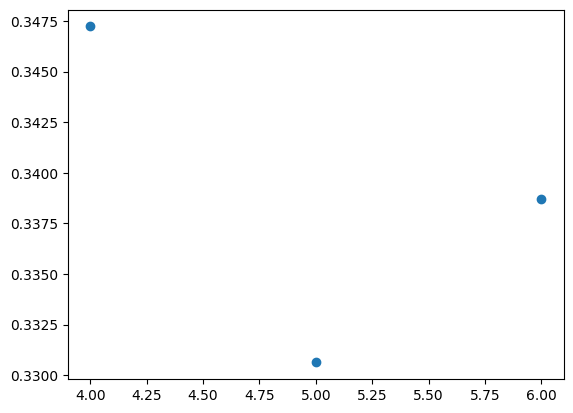

In [58]:
plt.scatter(x=k_values, y=silhouette)

In [49]:
 ### k-means model with k clusters
k_means = KMeans(n_clusters = 5)

model_vars = (
    delta_reflectance_df
    [[1, 2, 3, 4, 5, 6, 7, 9]])

### fit the model to the spectral bands
k_means.fit(model_vars)

### add the cluster labels to the dataframe
delta_reflectance_df['cluster'] = k_means.labels_

### inspect labels
delta_reflectance_df

band                               1         2         3         4         5  \
y            x                                                                 
3.303783e+06 810148.062907  0.092506  0.098571  0.116750  0.113867  0.136400   
             810178.062907  0.103206  0.104512  0.114637  0.112000  0.144058   
             810208.062907  0.109973  0.099300  0.118547  0.116637  0.149332   
             810238.062907  0.096147  0.099444  0.122821  0.119905  0.175626   
             810268.062907  0.097106  0.106341  0.124795  0.122558  0.184095   
...                              ...       ...       ...       ...       ...   
3.287163e+06 793768.062907  0.051573  0.061294  0.099711  0.085644  0.096339   
             793798.062907  0.058020  0.064039  0.102111  0.088633  0.099867   
             793828.062907  0.056827  0.066406  0.101100  0.088367  0.103367   
             793858.062907  0.055120  0.065529  0.097628  0.085950  0.103506   
             793888.062907  0.053081  0.066194  0.101918  0.092347  0.108239   

band                               6         7         9  cluster  
y            x                                                     
3.303783e+06 810148.062907  0.103026  0.088632  0.014737        1  
             810178.062907  0.106989  0.091905  0.014695        1  
             810208.062907  0.111784  0.095342  0.014689        1  
             810238.062907  0.123053  0.100505  0.014537        1  
             810268.062907  0.127484  0.103700  0.014526        1  
...                              ...       ...       ...      ...  
3.287163e+06 793768.062907  0.071561  0.057672  0.007422        1  
             793798.062907  0.071644  0.058033  0.007250        1  
             793828.062907  0.074917  0.060200  0.007344        1  
             793858.062907  0.077811  0.061667  0.007994        1  
             793888.062907  0.080917  0.063617  0.008061        1  

[317933 rows x 9 columns]

## STEP 5: PLOT

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Create a plot that shows the k-means clusters next to an RGB image of
the area. You may need to brighten your RGB image by multiplying it by
10. The code for reshaping and plotting the clusters is provided for you
below, but you will have to create the RGB plot yourself!</p>
<p>So, what is <code>.sortby(['x', 'y'])</code> doing for us? Try the
code without it and find out.</p></div></div>

In [64]:
# Plot the k-means clusters

rgb = delta_reflectance_da.sel(band=[4, 3, 2]) # blue, green, red
rgb_uint8 = (rgb * 255).astype(np.uint8).where(rgb!=np.nan)

# Brighten RGB image
rgb_bright = rgb_uint8 * 5
rgb_sat = rgb_bright.where(rgb_bright < 255, 255)

(
    rgb_sat.hvplot.rgb( 
        x='x', y='y', bands='band',
        data_aspect=1,
        xaxis=None, yaxis=None)
    + 
    delta_reflectance_df.cluster.to_xarray().sortby(['x', 'y']).hvplot(
        cmap="Colorblind", aspect='equal') 
)

:Layout
   .RGB.I   :RGB   [x,y]   (R,G,B)
   .Image.I :Image   [x,y]   (cluster)

**Spectral Signatures of the Manuel Canal-Spanish Lake Watershed**

The plot depicts observed clusters of spectral signatures in the watershed. With bands ranging across varying wavelengths, a silhoutte analysis was performed to select the optimal number of clusters. Five clusters achieved the best score for intracluster similarity and out-of-cluster distinction. This score likely fits the simplified scope of the bands (aerosol, red, green, blue, and infrared), but could indicate a less discernable clustering pattern that may be traced out by a principal component analysis or evidenced by the [marsh ecology](https://www2.tulane.edu/~bfleury/envirobio/saltmarsh.html). Salt marshes exhibit clear zonation as a result of levels of salinity and inudation which appear to be reflected in the clustering.
